In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import matplotlib.pyplot as plt

fontsize = 30
fontweight = 'bold'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import scipy.stats as st

import sklearn as sk
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_predict
from libtlda.iw import ImportanceWeightedClassifier

In [3]:
# Data locations
data_dir = 'data/UCI-hdis/'
write_dir = 'viz/'

# Hospital location
hospX = 'Budapest, Hungary'
hospX_ = 'budapest'
hospZ = 'Long Beach, CA, USA'
hospZ_ = 'longbeach'

In [4]:
# Features
feats = ['age','sex','pain','BP','chol','fbs','ecg','maxhr','eiang','eist','slope','vessels','thal','diagnosis']

# Import and read data
X = pd.read_csv(data_dir + 'processed.hungarian.data', names=feats, na_values='?')
Z = pd.read_csv(data_dir + 'processed.virginia.data', names=feats, na_values='?')

# Map classes to binary
y = ((X['diagnosis'] > 0).astype(int)).values
u = ((Z['diagnosis'] > 0).astype(int)).values

In [5]:
X0 = X['age'].values
X1 = X['chol'].values

X0[np.isnan(X0)] = 0
X1[np.isnan(X1)] = 0

XX = np.vstack((X0, X1)).T

Z0 = Z['age'].values
Z1 = Z['chol'].values

Z0[np.isnan(Z0)] = 0
Z1[np.isnan(Z1)] = 0

ZZ = np.vstack((Z0, Z1)).T

In [6]:
XXy0 = np.vstack((X0[y==0][:168], X1[y==0][:168])).T
XXy1 = np.vstack((X0[y==1][18:], X1[y==1][18:])).T
XX = np.vstack((XXy0, XXy1))
yy = np.vstack((np.zeros((168,1), dtype='uint8'), np.ones((88,1), dtype='uint8')))[:,0]

In [7]:
# Generate grid
tx, ty = np.mgrid[20:80:.1, 50:650:1]
grid = np.c_[tx.ravel(), ty.ravel()]

# Range limits for features
age_lim = [20, 80]
chol_lim = [50, 650]

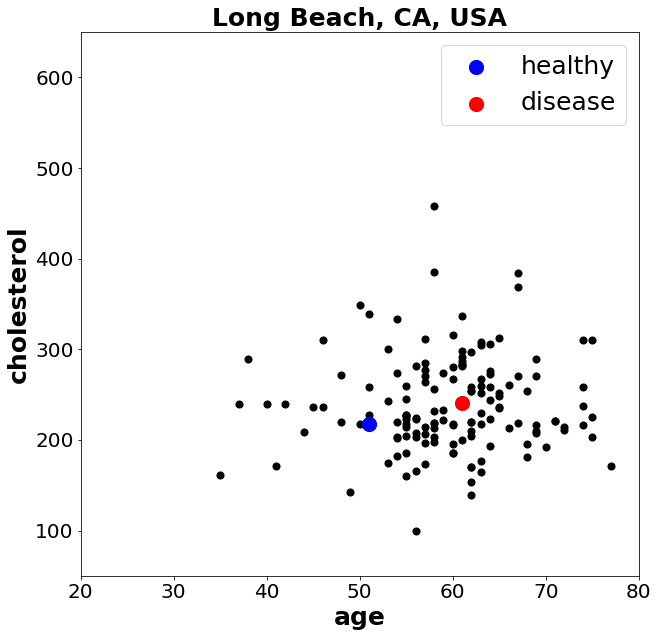

In [8]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(Z0[u==0], Z1[u==0], s=50, c='k')
ax.scatter(Z0[u==1], Z1[u==1], s=50, c='k')
ax.scatter(Z0[u==0][17], Z1[u==0][17], s=200, c='b', label='healthy')
ax.scatter(Z0[u==1][60], Z1[u==1][60], s=200, c='r', label='disease')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_xlim(age_lim)

ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)
ax.set_ylim(chol_lim)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN_semi-supervised.png', bbox_inches='tight', padding='none')

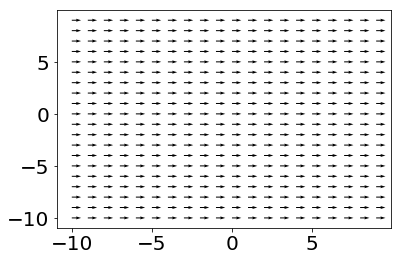

In [20]:
# Make a quiver for the translation

dxy = [5, 0]

X = np.arange(-10, 10, 1)
Y = np.arange(-10, 10, 1)
U, V = np.meshgrid(X, Y)

fig, ax = plt.subplots()
q = ax.quiver(U, V, dxy[0], dxy[1])
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# ax.quiverkey(q, X=1., Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')

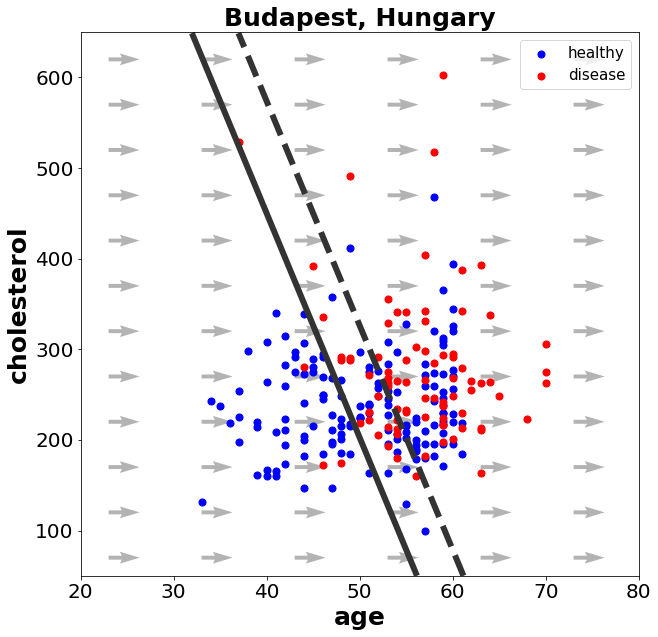

In [42]:
clfN = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.0).fit(XX, yy)
probsN = clfN.predict_proba(grid)[:, 1].reshape(tx.shape)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

XX0 = XX[yy==0,:]
XX1 = XX[yy==1,:]

XX0 = XX0 + [5, 0]
XX1 = XX1 + [5, 0]

# Train classifier
clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.0).fit(np.vstack((XX0, XX1)), yy)

# Make predictions
probs = clf.predict_proba(grid)[:, 1].reshape(tx.shape)

X = np.arange(age_lim[0]+3, age_lim[1]+3, 10)
Y = np.arange(chol_lim[0]+20, chol_lim[1]+20, 50)
U, V = np.meshgrid(X, Y)
ax.quiver(U, V, dxy[0], dxy[1], color=[.7,.7,.7])

ax.scatter(XX0[:,0], XX0[:,1], s=50, c='b', label='healthy')
ax.scatter(XX1[:,0], XX1[:,1], s=50, c='r', label='disease')

ax.legend(fontsize=fontsize-10, loc=1)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)

ax.set_title(hospX, fontsize=fontsize, fontweight=fontweight)

ax.set_xlim(age_lim)
ax.set_ylim(chol_lim)

ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')
ax.contour(tx, ty, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospX_ + '_age-chol_n256_submap.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospX_ + '_age-chol_n256_submap.eps', bbox_inches='tight', padding='none')


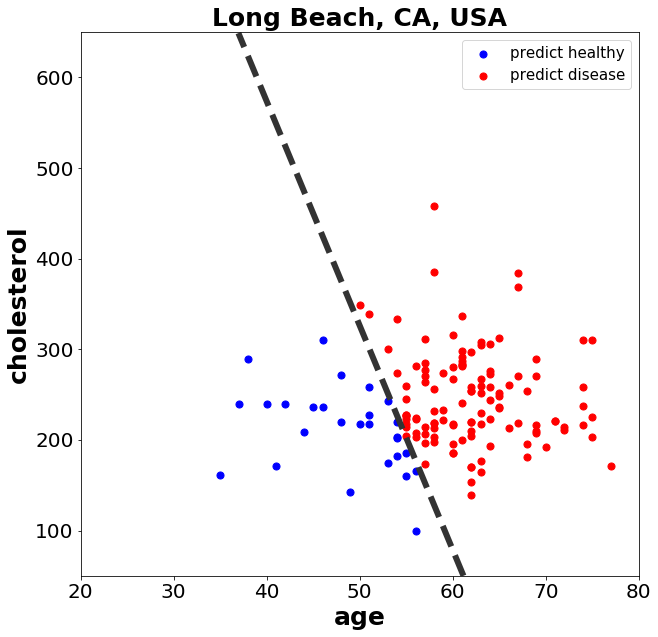

In [37]:
clfN = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.0).fit(XX, yy)
probsN = clfN.predict_proba(grid)[:, 1].reshape(tx.shape)

preds = (clf.predict(ZZ)).astype('uint8')

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(ZZ[preds==0, 0], ZZ[preds==0, 1], s=50, c='b', label='predict healthy')
ax.scatter(ZZ[preds==1, 0], ZZ[preds==1, 1], s=50, c='r', label='predict disease')

ax.legend(fontsize=fontsize-10)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

ax.set_xlim(age_lim)
ax.set_ylim(chol_lim)

# ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')
ax.contour(tx, ty, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_n256_submap_preds.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_n256_submap_preds.eps', bbox_inches='tight', padding='none')


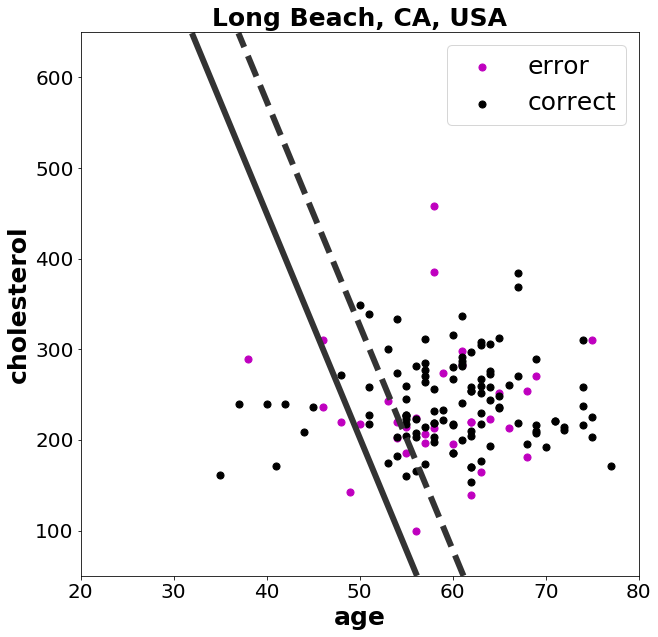

In [11]:
clfN = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.0).fit(XX, yy)
probsN = clfN.predict_proba(grid)[:, 1].reshape(tx.shape)

preds = (clf.predict(ZZ)).astype('uint8')
correct = (preds == u).astype('uint8')

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(Z0[correct==0], Z1[correct==0], s=50, c='m', label='error')
ax.scatter(Z0[correct==1], Z1[correct==1], s=50, c='k', label='correct')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

ax.set_xlim(age_lim)
ax.set_ylim(chol_lim)

ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')
ax.contour(tx, ty, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_n256_inv.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_n256_correct_inv.eps', bbox_inches='tight', padding='none')
